<div>
<img src="https://www.automation.com/getmedia/3c46e651-52ef-4d7e-9ee1-4e2132173f57/EUS031---Image" width="250" align="left"/>
</div>

## Reinforcement Learning Final Project: Inventory Management
Group 6: Michael, Annie, Targoon

In [3]:
# 1. Problem Introduction
    # - EDA / Markov Process Description
# 2. Solve Problem in a small scale (Value Iteration)
    # - Calculate Probability Matrix & Rewards by simulation
    # - plot different graphs between optimal action vs initial state given different values
# 3. Increase problem scaling (Value Iteration with Simulation & Q-Learning)

### Necessary imports

In [40]:
import gym
from gym import spaces
from gym import utils
from gym.utils import seeding

import logging
logger = logging.getLogger(__name__)

import os
from os.path import basename
import sys
import platform

import gym
from gym import spaces
from gym import utils
from gym.utils import seeding

import pandas as pd
import numpy as np
import quantecon as qe

import matplotlib.pyplot as plt

from collections import Counter
from itertools import groupby

import warnings
warnings.filterwarnings("ignore") # supress warnings

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_row', 20) # set max row display
pd.set_option('display.max_columns', 20) # set max column width

# enable ability to see the value of multiple statements at once
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [5]:
# check python version
from platform import python_version
print(python_version())

3.7.8


"A controller receives the controlled
system's state and a reward associated with the last state transition."

### Instantiate class from gym environment

In [6]:
class InventoryEnv(gym.Env, utils.EzPickle):
    """Inventory control with lost sales environment

    TO BE EDITED

    This environment corresponds to the version of the inventory control
    with lost sales problem described in Example 1.1 in Algorithms for
    Reinforcement Learning by Csaba Szepesvari (2010).
    https://sites.ualberta.ca/~szepesva/RLBook.html
    """

    def __init__(self, n=10, k=1, c=2, h=0, p=5, lam=5, ): # default values
        self.n = n 
        self.action_space = spaces.Discrete(n + 1)
        self.observation_space = spaces.Discrete(n + 1)
        self.max = n # have to optimize max items held at certain
        self.state = np.random.choice(range(n + 1))
        self.k = k # fixed entry cost for ordering; k must be greater than 0
        self.c = c # fixed price of purchase for items
        self.h = h # proportionality value must be greater than 0; cost per unit; constant that we multiply by remaining inventory
        self.p = p # p is price and must be greater than 0
        self.lam = lam
        
        # we do not know what demand will be 
        # upon selling z units the manager is paid the monetary amount of p z, where p > 0.

        # Set seed
        self._seed()

        # Start the first round
        self._reset()

    def demand(self):
        return np.random.poisson(self.lam) # randomly generated demand based on poisson distribution

    # transition probabilities
    def transition(self, x, a, d): # action At gives the number of items ordered in the evening of day t
        # x is initial state
        
        m = self.max
        
        # size of next inventory is xt+1
        return max(min(x + a, m) - d, 0) # subtract the d (demand) that you will recieve the next day

    def reward(self, x, a, y):
        k = self.k
        m = self.max # m is equal to n
        c = self.c
        h = self.h
        p = self.p
        if a + x > self.max:
            return -99999
        else:
            r = -k * (a > 0) - c * max(min(x + a, m) - x, 0) - h * x + p * max(min(x + a, m) - y, 0)
        return r

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _step(self, action):
        assert self.action_space.contains(action)
        obs = self.state
        demand = self.demand()
        obs2 = self.transition(obs, action, demand)
        self.state = obs2
        reward = self.reward(obs, action, obs2)
        done = 0
        return obs2, reward, done, {}

    def _reset(self):
        return self.state

### EDA

In [ ]:
col_name = []

for s in range(5):
    for e in range(3):
        col_name.append((s,e))

# prepare (s, e) column names
col_name 

We are going to start with a smaller sample set.

### Step 1: Transition probability and Reward matrices

In [8]:
env = InventoryEnv()

In [9]:
P_t = np.zeros([env.n + 1, env.n + 1, env.n + 1]) #(action, current_state, next_state)

RR = np.zeros([env.n + 1, env.n + 1, env.n + 1]) 

# 11 x 11 x 11
RR.shape

(11, 11, 11)

In [10]:
P_t.shape

(11, 11, 11)

In [11]:
#simulate demands 
T = 10000

# action 10, transitioning from state 0 to state x
#range(env.n + 1)

demand_list = []

for init_state in range(env.n + 1):
    for action in range(env.n + 1):
        final_state_list = []
        
        for i in range(T):
            demand = env.demand()
            final_state = env.transition(init_state, action, demand)
            
            demand_list.append(demand)
            final_state_list.append(final_state)
            
            
        final_state_count = Counter(final_state_list)
        
        
        for (final_state,probability) in final_state_count.items():
            P_t[action, init_state, final_state] = probability / T
            
        for final_state in range(env.n + 1):
            RR[action, init_state, final_state] = env.reward(init_state, action, final_state)

(array([4.87310e+04, 2.72078e+05, 4.24402e+05, 3.03262e+05, 1.23090e+05,
        3.18090e+04, 5.75500e+03, 7.99000e+02, 6.80000e+01, 6.00000e+00]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

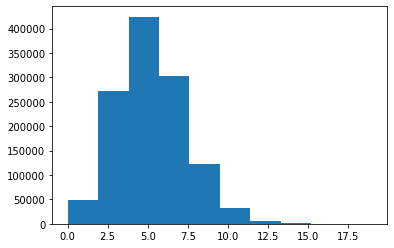

In [12]:
plt.hist(demand_list)

In [13]:
pd.DataFrame(P_t[5,:,:])

,0,1,2,3,4,5,6,7,8,9,10
0,0.5571,0.1841,0.1408,0.0788,0.0314,0.0078,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.3836,0.1745,0.1748,0.1383,0.0874,0.0353,0.0061,0.0000,0.0000,0.0000,0.0000
2,0.2406,0.1451,0.1742,0.1794,0.1419,0.0827,0.0296,0.0065,0.0000,0.0000,0.0000
3,0.1284,0.1017,0.1507,0.1795,0.1777,0.1389,0.0822,0.0345,0.0064,0.0000,0.0000
4,0.0701,0.0713,0.1046,0.1420,0.1732,0.1758,0.1373,0.0836,0.0357,0.0064,0.0000
5,0.0294,0.0351,0.0653,0.1016,0.1446,0.1784,0.1756,0.1441,0.0868,0.0324,0.0067
6,0.0317,0.0370,0.0583,0.1040,0.1483,0.1775,0.1767,0.1400,0.0865,0.0330,0.0070
7,0.0326,0.0364,0.0666,0.1060,0.1479,0.1751,0.1744,0.1415,0.0804,0.0320,0.0071
8,0.0328,0.0360,0.0653,0.1060,0.1478,0.1685,0.1782,0.1422,0.0836,0.0343,0.0053
9,0.0295,0.0378,0.0682,0.1046,0.1457,0.1776,0.1741,0.1376,0.0845,0.0342,0.0062


In [33]:
K,N,M = P_t.shape
K,N,M

(11, 11, 11)

In [15]:
# k = action
# i = current state
# j = next state

### Step 2: Value Iteration

In [38]:
q = np.zeros((K,N,1),dtype=np.float64) 
q.shape # creates eleven 11 x 1 arrays

(11, 11, 1)

In [39]:
for k in range(0,K):
    print(k)
    for j in range(0,M):
        print(j)

0
0
1
2
3
4
5
6
7
8
9
10
1
0
1
2
3
4
5
6
7
8
9
10
2
0
1
2
3
4
5
6
7
8
9
10
3
0
1
2
3
4
5
6
7
8
9
10
4
0
1
2
3
4
5
6
7
8
9
10
5
0
1
2
3
4
5
6
7
8
9
10
6
0
1
2
3
4
5
6
7
8
9
10
7
0
1
2
3
4
5
6
7
8
9
10
8
0
1
2
3
4
5
6
7
8
9
10
9
0
1
2
3
4
5
6
7
8
9
10
10
0
1
2
3
4
5
6
7
8
9
10


In [16]:
for i in range(0,N):
    for k in range(0,K):
        for j in range(0,M):
            q[k,i,0] = q[k,i,0] + RR[k,i,j]*P_t[k,i,j]

In [17]:
#value iteration
t=600
v = np.zeros((N,t),dtype=np.float64)
d = np.zeros((N,t),dtype=np.float64)
for n in range(1,t):   
    for i in range(0,N):
        rhs = np.zeros((1,K),dtype=np.float64)
        for k in range(0,K):
            rhs[0][k] = q[k][i][0] + np.matmul(P_t[k,i,:],v[:,n-1]) 
        v[i,n] = max(rhs[0])
        d[i,n] = np.argmax(rhs[0])
v = v.T
d = d.T

In [18]:
value_df = pd.DataFrame(v)

In [19]:
policy_df = pd.DataFrame(d)

In [20]:
value_df

,0,1,2,3,4,5,6,7,8,9,10
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.666500,11.623500,13.563500,15.536500,17.848500,20.694000,22.537000,23.760000,24.270500,24.696000,24.857500
2,23.786630,25.752035,27.782814,29.702435,31.813345,33.700079,35.743034,38.013793,40.434163,42.719117,44.690053
3,37.822259,39.872217,41.889769,43.685634,45.764875,47.713985,49.864888,52.018659,54.331336,56.621127,58.795030
4,51.839760,53.887471,55.906279,57.701834,59.781523,61.730701,63.881881,66.058574,68.363849,70.646793,72.811079
...,...,...,...,...,...,...,...,...,...,...,...
595,8338.046272,8340.093848,8342.112748,8343.908407,8345.988052,8347.937283,8350.088237,8352.261119,8354.567014,8356.851404,8359.017519
596,8352.066925,8354.114501,8356.133401,8357.929060,8360.008705,8361.957936,8364.108889,8366.281772,8368.587667,8370.872057,8373.038172
597,8366.087578,8368.135153,8370.154054,8371.949713,8374.029357,8375.978589,8378.129542,8380.302424,8382.608320,8384.892709,8387.058824
598,8380.108230,8382.155806,8384.174706,8385.970365,8388.050010,8389.999242,8392.150195,8394.323077,8396.628973,8398.913362,8401.079477


In [21]:
policy_df.tail(10)

,0,1,2,3,4,5,6,7,8,9,10
590,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
591,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
592,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
593,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
594,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
595,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
596,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
597,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
598,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0
599,10.0,9.0,8.0,7.0,6.0,5.0,4.0,0.0,0.0,0.0,0.0


### Step 3: Value Iteration by Simulation

In [22]:
# compute the expected reward (immediate)
q = np.zeros((K,N,1),dtype=np.float64)

for i in range(0,N):
    for k in range(0,K):
        for j in range(0,M):
            q[k,i,0] = q[k,i,0] + RR[k,i,j]*P_t[k,i,j]

# number of episodes
T=1000

v = np.zeros((N,T+1),dtype=np.float64)
d = np.zeros((N,T+1),dtype=np.int)
visits = np.zeros((N,1),dtype=np.int)

# maximum number of transitions (=maximum number of simulations -1)
Tmax = 1000

for n in range(1,T):
    t = 1
    y0 = 10
    while (t<=Tmax+1):
        visits[y0]+=1
        for i in range(0,N):
            if i==y0:
                rhs = np.zeros((1,K),dtype=np.float64)
                for k in range(0,K):
                    rhs[0][k] = q[k][i][0] + np.matmul(P_t[k,i,:],v[:,n-1]) 
                v[i,n] = max(rhs[0])
                if np.random.uniform(0,1,1)>=0.1:
                    d[i,n] = np.argmax(rhs[0])
                else:
                    d[i,n] = np.random.choice(range(0,K))
        y1 = np.random.choice(range(0,N),p=P_t[d[y0,n],y0,:])
        y0 = y1
        t = t+1
    v[:,n+1] = v[:,n]
    d[:,n+1] = d[:,n]
    
v = v.T
d = d.T

In [23]:
pd.DataFrame(d)

,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,0,0
1,5,4,0,3,0,0,9,0,0,0,7
2,9,6,8,6,5,4,4,0,0,0,2
3,10,9,8,7,6,0,4,0,0,0,0
4,10,9,8,7,6,5,4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
996,10,9,8,7,6,5,4,0,0,0,0
997,10,9,10,7,6,5,4,0,0,4,0
998,10,9,4,7,6,5,4,0,0,0,0
999,10,9,8,7,6,5,4,0,0,0,0


### Step 4: Q-Learning (Need to be fixed)

In [24]:
env = InventoryEnv()
T=10000 #number of episodes
v = np.zeros((env.n + 1,T+1),dtype=np.float64) #value
d = np.zeros((env.n + 1,T+1),dtype=np.int) #policy
visits = np.zeros((env.n + 1,env.n + 1),dtype=np.int) #current/action

Q = np.zeros((env.n + 1,env.n + 1),dtype=np.float64)

# maximum number of transitions (=maximum number of simulations -1)
Tmax = 1000

learning_rate = 0.01
for num_ep in range(1,T):
    t = 1
    env = InventoryEnv()
    current_state = env.state
    while (t <= Tmax+1):
        visits[current_state,action]+=1
        if t < Tmax / 2:
            if np.random.uniform(0,1,1)>=((Tmax - t) / Tmax):
                action = np.argmax(Q[y1,:]) #greedy
            else:
                action = np.random.choice(range(0,K)) #explore
        else:
            action = np.argmax(Q[y1,:]) #greedy

        #print("state: " + str(env.state))
        next_state, reward, done, z = env._step(action)
        #print("action: " + str(action))
        #print("next state: " + str(env.state))
        
        Q[current_state,action] = (1-learning_rate)*Q[current_state,action] + learning_rate*(reward + 
                                                                            0.99 * max(Q[next_state,:]))      
        current_state = env.state
        t += 1

In [25]:
J = np.zeros((env.n + 1,1),dtype=np.float64)
d = np.zeros((env.n + 1,1),dtype=np.float64)
for j in range(0,env.n + 1):
    J[j,0] = max(Q[j,:])
    d[j,0] = np.argmax(Q[j,:])

In [26]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10
0,1380.069682,1382.052580,1384.952558,1387.548973,1389.788964,1390.867799,1392.535241,1392.857162,1392.531595,1393.682629,1394.002618
1,1385.062943,1386.904283,1389.911495,1391.708465,1393.387247,1394.738849,1395.509268,1395.599945,1396.344172,1395.759407,-98608.878712
2,1389.902353,1391.716744,1393.781749,1395.452785,1396.773205,1397.296700,1397.665280,1398.169994,1398.120200,-98609.225264,-98609.389096
3,1394.461374,1395.889188,1397.217753,1398.796468,1399.746260,1399.042794,1399.096477,1400.045100,-98609.043908,-98609.165932,-98609.138443
4,1398.452879,1399.628583,1400.543407,1401.673866,1401.527941,1402.125422,1401.475903,-98609.467024,-98609.680151,-98609.142481,-98609.226751
5,1401.722905,1403.019034,1403.404024,1403.607728,1403.714106,1403.608700,-98609.148924,-98609.140387,-98609.222781,-98608.901629,-98609.614912
6,1405.594386,1404.921163,1405.213749,1405.635967,1404.902890,-98609.177487,-98609.009092,-98609.730334,-98609.274965,-98609.214967,-98609.257372
7,1407.888153,1407.483847,1407.253046,1408.459493,-98609.075769,-98609.277059,-98608.593435,-98609.478333,-98609.122386,-98609.654063,-98609.234134
8,1409.509667,1409.657606,1409.208866,-98609.082940,-98609.356435,-98609.364881,-98609.630825,-98609.726377,-98609.727369,-98609.434523,-98609.963522
9,1410.725230,1409.604108,-98610.252669,-98609.216663,-98610.597423,-98611.022261,-98611.660542,-98611.553638,-98610.797028,-98611.122237,-98611.301058


In [27]:
pd.DataFrame(d)

,0
0,10.0
1,8.0
2,7.0
3,7.0
4,5.0
5,4.0
6,3.0
7,3.0
8,1.0
9,0.0


In [28]:
T=5000 #number of episodes
v = np.zeros((N,T+1),dtype=np.float64) #value
d = np.zeros((N,T+1),dtype=np.int) #policy
visits = np.zeros((N,K),dtype=np.int)

Q = np.zeros((N,K),dtype=np.float64)

# maximum number of transitions (=maximum number of simulations -1)
Tmax = 1000

gamma = 0.1
for num_ep in range(1,T):
    t = 1
    y0 = np.random.choice(range(0,N))
    d0 = np.random.choice(range(0,K))
    while (t<=Tmax+1):
        visits[y0,d0]+=1
        y1 = np.random.choice(range(0,N),p=P_t[d0,y0,:])
        Q[y0,d0] = (1-gamma)*Q[y0,d0] + gamma*(RR[d0,y0,y1] + 0.95 * max(Q[y1,:]))
        y0 = y1
        if np.random.uniform(0,1,1)>=0.2:
            d0 = np.argmax(Q[y1,:]) #greedy
        else:
            d0 = np.random.choice(range(0,K)) #explore
        t = t+1


J = np.zeros((N,1),dtype=np.float64)
d = np.zeros((N,1),dtype=np.float64)
for j in range(0,N):
    J[j,0] = max(Q[j,:])
    d[j,0] = np.argmax(Q[j,:])

In [29]:
policy_df = pd.DataFrame(d)

In [30]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,10
0,256.322705,258.305181,261.362614,264.150128,265.921936,266.625750,267.318297,267.233664,267.315835,268.401235,267.465249
1,261.169906,262.227436,264.433137,267.578314,269.080594,268.820450,268.574501,268.826775,268.941289,269.194871,-99733.225639
2,266.608317,268.103554,269.293296,272.075507,272.125453,272.204830,271.226387,271.721332,271.652109,-99732.447266,-99732.709349
3,270.357790,272.882987,272.782210,272.437472,275.883720,272.153461,274.039327,272.637847,-99733.112687,-99733.698402,-99732.010511
4,274.580287,274.308963,274.445311,275.147569,275.245249,278.035030,275.228604,-99733.545083,-99732.886399,-99732.882940,-99733.766568
5,277.230181,277.814670,277.197823,276.926541,276.915858,277.352567,-99733.745362,-99732.859938,-99731.510280,-99733.222777,-99731.721346
6,279.296926,277.397553,279.451174,279.375461,282.169019,-99733.069584,-99731.769897,-99731.949212,-99732.725786,-99733.089208,-99731.930040
7,285.415004,281.241682,280.219799,281.630737,-99732.540629,-99733.522071,-99731.987813,-99735.679350,-99731.712252,-99735.365281,-99734.279712
8,282.300317,283.689546,282.326151,-99734.006055,-99733.776883,-99733.584613,-99732.258841,-99733.791272,-99734.193325,-99733.853319,-99733.889616
9,290.745340,284.397442,-99732.259282,-99734.553708,-99733.888545,-99733.131533,-99731.792610,-99733.913948,-99732.452355,-99732.896677,-99732.949147


In [31]:
policy_df

,0
0,9.0
1,9.0
2,5.0
3,4.0
4,5.0
5,1.0
6,4.0
7,0.0
8,1.0
9,0.0


### Step 4: Simulate withour probability matrix/RR

### Step 5: